# 8. Dataset and DataLoader

L'idea è quella di dividere il dataset in batch. Questo può essere fatto attraverso pytorch

## 8.1. basic information

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

In [3]:
class WineDataset(Dataset):
    def __init__(self):
        xy = np.loadtxt('wine.csv',delimiter=',',dtype=np.float32,skiprows=1)
        self.x = torch.from_numpy(xy[:,1:])
        self.y = torch.from_numpy(xy[:,[0]]) # n_samples,1
        self.n_samples = xy.shape[0]


    def __getitem__(self, index):
        return self.x[index],self.y[index]
    def __len__(self):
        return self.n_samples

In [4]:
dataset = WineDataset()

In [5]:
first_data = dataset[0]
features, labels = first_data
print(features,labels)


tensor([1.4230e+01, 1.7100e+00, 2.4300e+00, 1.5600e+01, 1.2700e+02, 2.8000e+00,
        3.0600e+00, 2.8000e-01, 2.2900e+00, 5.6400e+00, 1.0400e+00, 3.9200e+00,
        1.0650e+03]) tensor([1.])


In [9]:
batch_size = 4
dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [10]:
num_epochs = 2
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/batch_size)
print(total_samples,n_iterations)


178 45


In [12]:

for epoch in range(num_epochs):
    for i, (inputs,labels) in enumerate(dataloader):
        if i%20 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, inputs {inputs.shape}')

epoch 1/2, step 1/45, inputs torch.Size([4, 13])
epoch 1/2, step 21/45, inputs torch.Size([4, 13])
epoch 1/2, step 41/45, inputs torch.Size([4, 13])
epoch 2/2, step 1/45, inputs torch.Size([4, 13])
epoch 2/2, step 21/45, inputs torch.Size([4, 13])
epoch 2/2, step 41/45, inputs torch.Size([4, 13])


## 8.2. Transform on dataset

In [ ]:
'''
dataset = torchvision.datasets.MNIST(
    root='./data',
    transform=torchvision.transforms.ToTensor(),
)
'''

In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

In [15]:
class WineDataset(Dataset):
    def __init__(self,transform=None):
        xy = np.loadtxt('wine.csv',delimiter=',',dtype=np.float32,skiprows=1)
        self.x = xy[:,1:]
        self.y = xy[:,[0]] # n_samples,1
        self.n_samples = xy.shape[0]

        self.transform = transform

    def __getitem__(self, index):
        sample = self.x[index],self.y[index]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def __len__(self):
        return self.n_samples

In [19]:
class ToTensor:
    def __call__(self,sample):
        inputs, labels = sample
        return torch.from_numpy(inputs),torch.from_numpy(labels)
    
class MulTransform:
    def __init__(self,factor):
        self.factor = factor
    def __call__(self,sample):
        inputs, labels = sample
        inputs *= self.factor
        return inputs, labels

In [16]:
dataset = WineDataset(transform=ToTensor())

In [17]:
first_data = dataset[0]
features, labels = first_data
print(features,labels)

tensor([1.4230e+01, 1.7100e+00, 2.4300e+00, 1.5600e+01, 1.2700e+02, 2.8000e+00,
        3.0600e+00, 2.8000e-01, 2.2900e+00, 5.6400e+00, 1.0400e+00, 3.9200e+00,
        1.0650e+03]) tensor([1.])


In [20]:
composed = torchvision.transforms.Compose([ToTensor(),MulTransform(2)])
dataset = WineDataset(transform=composed)

first_data = dataset[0]
features, labels = first_data
print(features,labels)

tensor([2.8460e+01, 3.4200e+00, 4.8600e+00, 3.1200e+01, 2.5400e+02, 5.6000e+00,
        6.1200e+00, 5.6000e-01, 4.5800e+00, 1.1280e+01, 2.0800e+00, 7.8400e+00,
        2.1300e+03]) tensor([1.])


# 9. Softmax and Cross Entropy

## 9.1. basic information

$$S(y_i) = \frac{\exp^{y_i}}{\sum_i \exp^{y_i}}$$

In [21]:
import torch
import torch.nn as nn
import numpy as np

In [22]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x),axis=0)

x = np.array([2.0,1.0,0.1])

outputs = softmax(x)

print('softmax numpy:',outputs)

softmax numpy: [0.65900114 0.24243297 0.09856589]


In [23]:
x = torch.tensor([2.0,1.0,0.1])

outputs = torch.softmax(x,dim=0)

print('softmax torch:',outputs)

softmax torch: tensor([0.6590, 0.2424, 0.0986])


Cross Entropy

$$H(p,q) = -\frac{1}{N} \sum_i Y_i \log \hat{Y_i}$$

In [24]:
def cross_entropy(actual,predicted):
    loss = -np.sum(actual*np.log(predicted))
    return loss

Y = np.array([1,0,0])

Y_pred_good = np.array([0.7,0.2,0.1])

Y_pred_bad = np.array([0.1,0.3,0.6])

l1 = cross_entropy(Y,Y_pred_good)

l2 = cross_entropy(Y,Y_pred_bad)

print(f'Loss1 numpy: {l1:.4f}')

print(f'Loss2 numpy: {l2:.4f}')



Loss1 numpy: 0.3567
Loss2 numpy: 2.3026


Nel caso della crossentropy nn.CrossEntropyLoss() fa già la softmax, quindi non è necessario aggiungerla.

Inoltre, basta mettere la giusta classe in Y, non serve l'one-hot encoding.

In [26]:

loss = nn.CrossEntropyLoss()

Y = torch.tensor([0])

# nsamples x nclasses = 1 x 3
Y_pred_good = torch.tensor([[2.0,1.0,0.1]])
Y_pred_bad = torch.tensor([[0.5,2.0,0.3]])

l1 = loss(Y_pred_good,Y)
l2 = loss(Y_pred_bad,Y)

print(f'PyTorch Loss1: {l1.item():.4f}')

print(f'PyTorch Loss2: {l2.item():.4f}')


 

PyTorch Loss1: 0.4170
PyTorch Loss2: 1.8406


In [27]:
_, predictions1 = torch.max(Y_pred_good,1)
_, predictions2 = torch.max(Y_pred_bad,1)

print(predictions1,predictions2)


tensor([0]) tensor([1])


La loss in pytorch permette di ricevere in input più di un sample alla volta

In [29]:
loss = nn.CrossEntropyLoss()

Y = torch.tensor([2,0,1])

# nsamples x nclasses = 1 x 3
Y_pred_good = torch.tensor([[2.0,1.0,10.0], [2.0,1.0,0.1],[2.0,10.0,0.1]])
Y_pred_bad = torch.tensor([[0.5,2.0,0.3],[0.5,2.0,0.3],[0.5,2.0,0.3]])

l1 = loss(Y_pred_good,Y)
l2 = loss(Y_pred_bad,Y)

print(f'PyTorch Loss1: {l1.item():.4f}')

print(f'PyTorch Loss2: {l2.item():.4f}')

PyTorch Loss1: 0.1393
PyTorch Loss2: 1.4073


## 9.2. Neural network

This NN can be used for classification

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super(NeuralNet,self).__init__()
        self.l1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size,num_classes)
    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no softmax !!! because it is included in the loss
        return out
    
model = NeuralNet(input_size=28*28,hidden_size=5,num_classes=3)
criterion = nn.CrossEntropyLoss()

If we have binary classification, we can use sigmoid function

In [ ]:
class NeuralNetBinary(nn.Module):
    def __init__(self,input_size,hidden_size):
        super(NeuralNet,self).__init__()
        self.l1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size,1)
    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # Sigmoid for binary classification
        out = torch.sigmoid(out)
        return out
    
model = NeuralNet(input_size=28*28,hidden_size=5,num_classes=3)
criterion = nn.CrossEntropyLoss()

# 10. Activation functions

Softmax utile per ultimo livello di una multiclasse

Le funzioni di attivazione possono essere aggiunte come attributi di classe o applicate direttamente nel forward

Sono disponibili sia in torch. o in torch.nn e anche torch.nn.functional. A esempio, la leaky relu è disponibile solo in torch functional

# 11. FFN

For MNIST

In [18]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
input_size = 784
hidden_size = 100
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001


In [7]:
train_dataset = torchvision.datasets.MNIST(
                        root='./data', 
                        train=True,
                        transform=transforms.ToTensor(), 
                        download=True
) 

test_dataset = torchvision.datasets.MNIST(
                        root='./data', 
                        train=False,
                        transform=transforms.ToTensor()
) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
train_loader = torch.utils.data.DataLoader(
                        dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=True
)

test_loader = torch.utils.data.DataLoader(
                        dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False
)


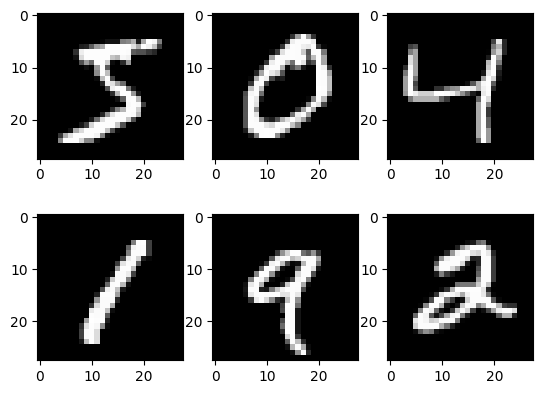

In [15]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(train_dataset[i][0].reshape(28,28),cmap='gray')
plt.show()

In [22]:
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super(NeuralNet,self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size,num_classes)
    def forward(self,x):
        out = self.flatten(x)
        out = self.l1(out)
        out = self.relu(out)
        out = self.l2(out)
        # no softmax cause we're using cross entropy
        # that includes softmax
        return out

In [23]:
model = NeuralNet(input_size,hidden_size,num_classes).to(device)

In [24]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [25]:
n_total_steps = len(train_loader)
n_total_steps

600

In [27]:
# training


for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        loss = criterion(outputs,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1)%100 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')


epoch 1/5, step 100/600, loss = 0.1158
epoch 1/5, step 200/600, loss = 0.0888
epoch 1/5, step 300/600, loss = 0.0549
epoch 1/5, step 400/600, loss = 0.1288
epoch 1/5, step 500/600, loss = 0.0715
epoch 1/5, step 600/600, loss = 0.1067
epoch 2/5, step 100/600, loss = 0.0439
epoch 2/5, step 200/600, loss = 0.1145
epoch 2/5, step 300/600, loss = 0.0683
epoch 2/5, step 400/600, loss = 0.0594
epoch 2/5, step 500/600, loss = 0.0541
epoch 2/5, step 600/600, loss = 0.0323
epoch 3/5, step 100/600, loss = 0.0559
epoch 3/5, step 200/600, loss = 0.0296
epoch 3/5, step 300/600, loss = 0.0377
epoch 3/5, step 400/600, loss = 0.0387
epoch 3/5, step 500/600, loss = 0.0541
epoch 3/5, step 600/600, loss = 0.0649
epoch 4/5, step 100/600, loss = 0.0692
epoch 4/5, step 200/600, loss = 0.0251
epoch 4/5, step 300/600, loss = 0.0427
epoch 4/5, step 400/600, loss = 0.0393
epoch 4/5, step 500/600, loss = 0.0214
epoch 4/5, step 600/600, loss = 0.0659
epoch 5/5, step 100/600, loss = 0.0339
epoch 5/5, step 200/600, 

In [28]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value,index)
        _,predictions = torch.max(outputs,1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}')

accuracy = 97.46


torch.Size([3, 1, 28, 28])
9, real labels: 4


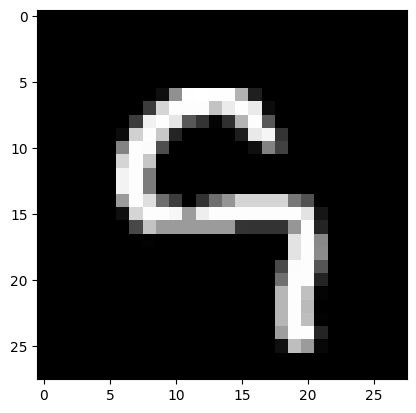

In [35]:

with torch.no_grad():
    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value,index)
        _,predictions = torch.max(outputs,1)
        wrong = (predictions != labels)
        miss_imgs = images[wrong]
        if miss_imgs.shape[0] == 0:
            continue
        print(miss_imgs.shape)
        miss_labels = labels[wrong]
        print(f"{predictions[wrong][1]}, real labels: {miss_labels[1]}")
        plt.imshow(miss_imgs[0].reshape(28,28),cmap='gray')
        break


# 12. Convolutional Neural Network

In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torc
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [1]:
num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])  

train_dataset = torchvision.datasets.CIFAR10(
                        root='./data',
                        train=True,
                        transform=transform,
                        download=True
)

test_dataset = torchvision.datasets.CIFAR10(
                        root='./data',
                        train=False,
                        transform=transform,
                        download=True
)

train_loader = torch.utils.data.DataLoader(
                        dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=True
)

test_loader = torch.utils.data.DataLoader(
                        dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False
)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [33]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(3,6,kernel_size=5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,kernel_size=5)
        self.ffl = nn.Sequential(
                            nn.Flatten(),
                            nn.Linear(16*5*5,120),
                            nn.ReLU(),
                            nn.Linear(120,84),
                            nn.ReLU(),
                            nn.Linear(84,10),
        )

    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.ffl(x)
        return x


model = ConvNet().to(device)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [36]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')


epoch 1/5, step 1/12500, loss = 2.3613
epoch 1/5, step 1001/12500, loss = 1.7559
epoch 1/5, step 2001/12500, loss = 1.4809
epoch 1/5, step 3001/12500, loss = 1.6062
epoch 1/5, step 4001/12500, loss = 1.6271
epoch 1/5, step 5001/12500, loss = 2.3314
epoch 1/5, step 6001/12500, loss = 2.2061
epoch 1/5, step 7001/12500, loss = 1.7150
epoch 1/5, step 8001/12500, loss = 1.5751
epoch 1/5, step 9001/12500, loss = 1.2920
epoch 1/5, step 10001/12500, loss = 1.2950
epoch 1/5, step 11001/12500, loss = 1.4124
epoch 1/5, step 12001/12500, loss = 1.1792
epoch 2/5, step 1/12500, loss = 2.0352
epoch 2/5, step 1001/12500, loss = 1.7764
epoch 2/5, step 2001/12500, loss = 2.5816
epoch 2/5, step 3001/12500, loss = 0.4466
epoch 2/5, step 4001/12500, loss = 1.9209
epoch 2/5, step 5001/12500, loss = 1.5830
epoch 2/5, step 6001/12500, loss = 1.5501
epoch 2/5, step 7001/12500, loss = 1.3234
epoch 2/5, step 8001/12500, loss = 1.2816
epoch 2/5, step 9001/12500, loss = 1.0983
epoch 2/5, step 10001/12500, loss = 1

In [37]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value,index)
        _,predicted = torch.max(outputs,1)
        n_samples += labels.shape[0]
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            if labels[i] == predicted[i]:
                n_class_correct[labels[i]]+=1
            n_class_samples[labels[i]] +=1

    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

accuracy = 59.81
Accuracy of plane: 62.6 %
Accuracy of car: 68.6 %
Accuracy of bird: 48.3 %
Accuracy of cat: 39.7 %
Accuracy of deer: 47.8 %
Accuracy of dog: 48.0 %
Accuracy of frog: 76.2 %
Accuracy of horse: 67.4 %
Accuracy of ship: 71.4 %
Accuracy of truck: 68.1 %
